# Regressão linear com regularização

## Bibliotecas

Serão utilizadas as bibliotecas numpy para a realização de operações matemáticas em array e matrizes multidimensionais, matplotlib para plotagem de gráficos, scipy para otimizar o modelo da regressão logística e para ler arquivos no formato *.mat*.

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import scipy.optimize as opt

## Importação dos dados

O dataset contém dados de registros históricos na mudança no nível de água, e na quantidade de água que sai de uma barragem.

In [150]:
data = spio.loadmat('data/ex5data1.mat', squeeze_me=True)
X, y = data['X'], data['y']
X_test, y_test = data['Xtest'], data['ytest']
X_val, y_val = data['Xval'], data['yval']
m = len(y)
m_val = len(y_val)
X_ones = np.stack([np.ones(m), X], axis=1)
X_val_ones = np.stack([np.ones(m_val), X_val], axis=1)

## Visualização de dados

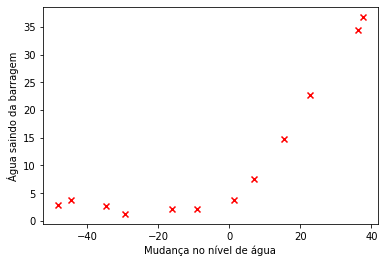

In [140]:
plt.scatter(X, y, color='red', marker='x')
plt.xlabel('Mudança no nível de água')
plt.ylabel('Água saindo da barragem')
plt.show()

## Função de custo

O termo de regularização $\lambda\sum_{j=1}^n \theta_j^2$ é adicionado a função de custo e impõe uma penalidade sobre o custo total, o hiperparâmetro $\lambda$ controla o grau de regularização imposto.

$$ J(\theta) = \frac{1}{2m} \sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)} \right)^2 + \lambda \sum_{j=1}^n \theta_j^2 $$

In [162]:
def compute_cost(theta, X, y, l):
    return (1 / (2 * m)) * (np.sum((X @ theta - y) ** 2) + l * np.sum(theta[1:] ** 2))

theta = np.ones(2)
print(f'Custo: {compute_cost(theta, X_ones, y, 1)}')

Custo: 303.9931922202643


## Gradiente

Para o gradiente não devemos penalizar o $\theta_0$, portanto deve ser separado dos outros parâmetros. O termo $\frac{\lambda}{m} \theta_j$ aplica a regularização nos demais parâmetros.

$$ \theta_0 := \theta_0 - \alpha \frac{1}{m} \sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)} \right) x_0^{(i)} $$
$$ \theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)} \right) x_j^{(i)} + \frac{\lambda}{m} \theta_j \qquad j \in \{1, 2, \ldots, n\} $$

In [163]:
def gradient(theta, X, y, L):
    grad = (X.T @ ((X @ theta) - y)) / m
    grad[1:] = grad[1:] + (L / m) * theta[1:]
    return grad

## Ajustando os parâmetros da regressão linear

Para o aprendizado dos parâmetros iremos utilizar a biblioteca scipy, a função *fmin_cg* recebe como parâmetros a função para computar o custo, o valor inicial dos parâmetros, a função que calcula a derivada do gradiente e valores do dataset para serem passados para as funções.

Parâmetros theta: [13.08771802  0.36774202]


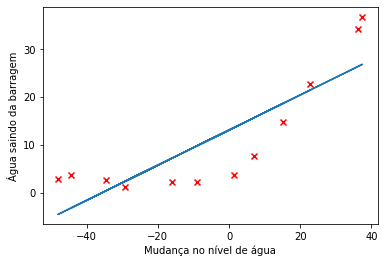

In [167]:
result = opt.fmin_cg(f=compute_cost, x0=theta, fprime=gradient, args=(X_ones, y, 1), disp=False)

print(f'Parâmetros theta: {result}')
plt.scatter(X, y, color='red', marker='x')
plt.plot(X, X_ones @ result)
plt.xlabel('Mudança no nível de água')
plt.ylabel('Água saindo da barragem')
plt.show()

# Viés e variância

## Curvas de aprendizado

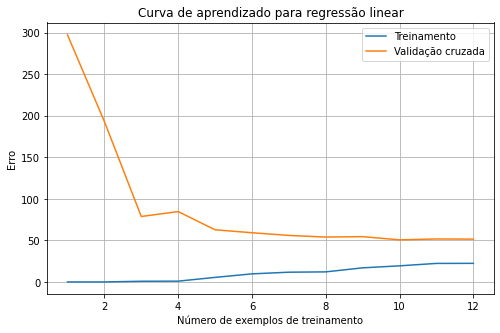

In [169]:
def learning_curve(theta, X, y, X_val, y_val, L):
    m = len(y)
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    for i in range(1, m + 1):
        theta_train = opt.fmin_cg(f=compute_cost, x0=theta, fprime=gradient, args=(X[:i], y[:i], L), disp=False)
        error_train[i - 1] = compute_cost(theta_train, X[:i], y[:i], L)
        error_val[i - 1] = compute_cost(theta_train, X_val, y_val, L)
    return error_train, error_val

error_train, error_val = learning_curve(theta, X_ones, y, X_val_ones, y_val, 0)

x_value = np.arange(1., len(error_train) + 1)
plt.figure(figsize=(8, 5))
plt.plot(x_value, error_train, label="Treinamento")
plt.plot(x_value, error_val, label="Validação cruzada")
plt.legend(loc="upper right")
plt.xlabel("Número de exemplos de treinamento")
plt.ylabel("Erro")
plt.title("Curva de aprendizado para regressão linear")
plt.grid(True)
plt.show()

Conforme pode ser observado no gráfico, o número de erros nos conjunto de treinamento e de validação cruzada são altos, indicando que o modelo possui um viés alto, ou seja, a regressão linear não consegue se ajustar ao conjunto de dados.